In [58]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import galsim as gs
from astropy.units import Unit as u
from astropy.units import deg
from pathlib import Path
from glob import glob
from astropy.coordinates import SkyCoord
from scipy.optimize import least_squares
import emcee
import corner

from kl_tools.utils import get_base_dir, build_map_grid
from kl_tools.velocity import VelocityMap
from kl_tools.priors import UniformPrior, GaussPrior

In [59]:
def get_kross_obj_data(kid, vb=False):
    kross_dir = get_base_dir() / 'data/kross'
    cosmo_dir = get_base_dir() / 'data/cosmos'
    kross_data = fitsio.read(kross_dir / 'kross_release_v2.fits', ext=1)

    # need all the coords for a match to the COSMOS cutouts
    kross_ra = kross_data['RA']
    kross_dec = kross_data['DEC']
    kross_names = kross_data['NAME']
    kross_coords = SkyCoord(ra=kross_ra*deg, dec=kross_dec*deg)

    # clean up the names
    for i, name in enumerate(kross_names):
        new = name.strip()
        kross_names[i] = new

    # get the KROSS sky coordinates to match to the COSMOS cutouts
    cosmo_files = glob(str(cosmo_dir / 'cutouts/*.fits'))
    cosmo_cutouts = {}
    for f in cosmo_files:
        fname = Path(f).name

        # match to the KROSS sky coordinates to get the obj name
        ra  = float(fname.split('_')[1])
        dec = float(fname.split('_')[2])
        coord = SkyCoord(ra=ra*deg, dec=dec*deg)

        indx, sep, _ = coord.match_to_catalog_sky(kross_coords)
        cosmo_cutouts[kross_names[indx]] = f

    row = kross_data[kross_data['KID'] == kid] 
    name = row['NAME'][0].strip()
    ra = kross_data['RA']
    dec = kross_data['DEC']

    cube_file = kross_dir / 'cubes' / f'{name}.fits'
    velocity_file = kross_dir / 'vmaps' / f'{name}.fits' 
    sigma_file = kross_dir / 'disp' / f'{name}.fits' 
    halpha_file = kross_dir / 'halpha' / f'{name}.fits'
    hst_file = cosmo_cutouts[name]

    # grab all of the object data
    try:
        cube, cube_hdr = fitsio.read(cube_file, header=True)
    except FileNotFoundError:
        if vb is True:
            print(f'Cube file not found: {cube_file}')
        cube, cube_hdr = None
    try:
        velocity, velocity_hdr = fitsio.read(velocity_file, header=True)
    except FileNotFoundError:
        if vb is True:
            print(f'Velocity map file not found: {velocity_file}')
        velocity, velocity_hdr = None, None
    try:
        sigma, sigma_hdr = fitsio.read(sigma_file, header=True)
    except FileNotFoundError:
        if vb is True:
            print(f'Sigma file not found: {sigma_file}')
        sigma, sigma_hdr = None, None
    try:
        halpha, halpha_hdr = fitsio.read(halpha_file, header=True)
    except FileNotFoundError:
        if vb is True:
            print(f'Halpha file not found: {halpha_file}')
        halpha, halpha_hdr = None, None
    try:
        hst, hst_hdr = fitsio.read(hst_file, header=True)
    except FileNotFoundError:
        if vb is True:
            print(f'HST file not found: {hst_file}')
        hst, hst_hdr = None, None

    obj_data = {
        'catalog': row,
        'cube': cube,
        'cube_hdr': cube_hdr,
        'velocity': velocity,
        'velocity_hdr': velocity_hdr,
        'sigma': sigma,
        'sigma_hdr': sigma_hdr,
        'halpha': halpha,
        'halpha_hdr': halpha_hdr,
        'hst': hst,
        'hst_hdr': hst_hdr
    }

    return obj_data

def vmap_theta2pars(theta):
    '''
    Map a fixed array of parameters to a dict of vmap parameters.

    We have more general tools to handle this, but this is a simple
    way to handle the fixed parameters in the KROSS model.
    '''

    pars = {
        'v0': theta[0],
        'vcirc': theta[1],
        'rscale': theta[2],
        'sini': theta[3],
        'theta_int': theta[4],
        'x0': theta[5],
        'y0': theta[6],
        'g1': 0.0,
        'g2': 0.0,
        'r_unit': u('pixel'),
        'v_unit': u('km/s'),
    }

    return pars

def vmap_pars2theta(pars):
    '''
    Map a dict of vmap parameters to a fixed array of parameters for the fitter

    We have more general tools to handle this, but this is a simple
    way to handle the fixed parameters in the KROSS model.
    '''

    theta = np.array([
        pars['v0'],
        pars['vcirc'],
        pars['rscale'],
        pars['sini'],
        pars['theta_int'],
        pars['x0'],
        pars['y0'],
    ])

    return theta

def imap_theta2pars(theta):
    pars = {
        'x0': theta[0],
        'y0': theta[1],
        'sini': theta[2],
        'theta_int': theta[3],
        'flux': theta[4],
        'hlr': theta[5],
        # ...
    }
    return pars

def imap_pars2theta(pars):
    theta = np.array([
        pars['x0'],
        pars['y0'],
        pars['sini'],
        pars['theta_int'],
        pars['flux'],
        pars['hlr'],
        # ...
    ])
    return theta

def theta2pars(theta):
    vmap_pars = vmap_theta2pars(theta[:7])
    imap_pars = imap_theta2pars(theta[7:])
    return vmap_pars, imap_pars

def vmap_residuals(vmap_pars, vmap_data, vmap_hdr, weights, mask, psf=None):

    if weights is None:
        weights = np.ones_like(vmap_data)
    if mask is None:
        mask = np.ones_like(vmap_data)

    # Get the grid
    Nrow, Ncol = vmap_data.shape
    Nx, Ny = Ncol, Nrow
    X, Y = build_map_grid(Nx, Ny, indexing='xy')

    vmap = VelocityMap('offset', vmap_pars)
    vmap_model = vmap('obs', X, Y) # render in the obs frame
    residuals = (
        (vmap_data - vmap_model) * np.sqrt(weights) * mask
        ).flatten()

    return residuals


def get_imap_model(imap_pars,imap_hdr,Nx,Ny,psf=None):
    
    x0 = imap_pars['x0']
    y0 = imap_pars['y0']
    flux = imap_pars['flux']
    hlr = imap_pars['hlr']
    sini = imap_pars['sini']
    theta_int = imap_pars['theta_int'] * gs.degrees

    inclination = gs.Angle(np.arcsin(sini), gs.radians)

    gal = gs.InclinedExponential(
        inclination, flux=flux, half_light_radius=hlr
    )
    gal = gal.rotate(theta_int)

    convolved = gs.Convolve(gal, psf)

    wcs = gs.GSFitsWCS(header=imap_hdr)
    imap_model = convolved.drawImage(
        nx=Nx, ny=Ny, wcs=wcs, offset=gs.PositionD(x0, y0)
        ).array
    return imap_model


def imap_residuals(imap_pars, imap_data, imap_hdr, weights, mask, psf=None):

    if weights is None:
        weights = np.ones_like(imap_data)
    if mask is None:
        mask = np.ones_like(imap_data, dtype=bool)

    # Get the grid
    Nrow, Ncol = imap_data.shape
    Nx, Ny = Ncol, Nrow
    imap_model = get_imap_model(imap_pars,imap_hdr,Nx,Ny,psf=psf)
    
    
    # NOTE: figure out if this is necessary for our residual calculation
    # imap_model = imap_model.swapaxes(0,1)

    residuals = (
        (imap_data - imap_model) * np.sqrt(weights) * mask
        ).flatten()

    return residuals

def residuals(
        theta,
        # both of these must have the same keys
        # - data
        # - hdr
        # - psf
        # - weights
        # - mask
        vmap_dict,
        imap_dict,
        imap_weight=0.5
        ):

    vmap_data = vmap_dict['data']
    vmap_hdr = vmap_dict['hdr']
    vmap_psf = vmap_dict['psf']
    vmap_weights = vmap_dict['weights']
    vmap_mask = vmap_dict['mask']

    imap_data = imap_dict['data']
    imap_hdr = imap_dict['hdr']
    imap_psf = imap_dict['psf']
    imap_weights = imap_dict['weights']
    imap_mask = imap_dict['mask']

    vmap_pars, imap_pars = theta2pars(theta)

    vmap_res = vmap_residuals(
        vmap_pars, vmap_data, vmap_hdr, vmap_weights, vmap_mask, vmap_psf
        )

    imap_res = imap_residuals(
        imap_pars, imap_data, imap_hdr, imap_weights, imap_mask, imap_psf
        )

    residuals = np.concatenate(
        ((1. - imap_weight) * vmap_res, imap_weight * imap_res)
        )

    return residuals

def log_posterior(theta, vmap_dict, imap_dict, priors):
    logprior = log_prior(theta, priors)
    if logprior == -np.inf:
        return -np.inf
    
    loglike = log_likelihood(theta, vmap_dict, imap_dict)
    logpost = loglike + logprior

    if np.isnan(logpost):
        logpost = -np.inf

    return logpost

def log_likelihood(theta, vmap_dict, imap_dict):
    return -0.5 * np.sum(residuals(theta, vmap_dict, imap_dict)**2)

def log_prior(theta, priors):
    logprior = 0
    for i, prior in enumerate(priors):
        logprior += prior(theta[i], log=True)

    return logprior

In [60]:
kross_dir = get_base_dir() / 'data' / 'kross'
kid = 171

# grab data
obj_data = obj = get_kross_obj_data(kid)

# construct a mask
vmap_mask = np.ones_like(obj_data['velocity'], dtype=bool)
vmap_mask[obj_data['velocity'] == 0] = 0

# now restructure the data for the fitter
vmap_dict = {
    'data': obj_data['velocity'],
    'hdr': obj_data['velocity_hdr'],
    'psf': None,
    'weights': None,
    'mask': vmap_mask
}
imap_dict = {
    'data': obj_data['hst'],
    'hdr': obj_data['hst_hdr'],
    'psf': gs.Gaussian(fwhm=0.05).shear(g1=0.1, g2=0.1),
    'weights': None,
    'mask': None
}

# initial guess
theta0 = np.array([
    # vmap parameters
    0, # v0
    130, # vcirc
    5, # rscale; pixels
    0.75, # sini
    1.0, # theta_int
    0, # x0
    0, # y0
    # imap parameters
    0, # x0
    0, # y0
    0.75, # sini
    1.0, # theta_int
    1000, # flux
    3, # hlr
])

# param names
param_names = [
    # vmap parameters
    'v0',
    'vcirc',
    'rscale',
    'sini',
    'theta_int',
    'g1',
    'g2',
    'x0',
    'y0',
    # imap parameters
    'x0_imap',
    'y0_imap',
    'sini_imap',
    'theta_int_imap',
    'flux_imap',
    'hlr_imap',
]

priors = [
    # vmap parameters
    GaussPrior(0, 10), # v0
    GaussPrior(130, 30, clip_sigmas=3), # vcirc
    UniformPrior(1, 10), # rscale; pixels
    UniformPrior(0., np.pi), # sini
    UniformPrior(0., 2*np.pi), # theta_int
    UniformPrior(-10, 10), # x0
    UniformPrior(-10, 10), # y0
    # imap parameters
    UniformPrior(-10, 10), # x0
    UniformPrior(-10, 10), # y0
    UniformPrior(0., 1.), # sini
    UniformPrior(0., 2*np.pi), # theta_int
    UniformPrior(1e2, 1e6), # flux
    UniformPrior(0.1, 10), # hlr
]

nwalkers, ndim = 100, len(theta0)
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_posterior,
    args=[vmap_dict, imap_dict, priors])

Nsteps = 5000
# start = theta0 + np.random.randn(nwalkers, ndim)
start = 1e-4 * np.random.randn(nwalkers, ndim)
for i in range(nwalkers):
    start[i,:] += theta0
#sampler.run_mcmc(start, Nsteps, progress=True)




   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.0414e-01                                    3.17e+00    
       1              2         2.0597e-01      1.98e-01       2.35e-01       1.73e+00    
       2              3         1.5690e-01      4.91e-02       5.74e-01       2.55e-01    
       3              4         1.4511e-01      1.18e-02       5.57e-01       7.73e-01    
       4              5         1.4176e-01      3.35e-03       1.41e+00       5.02e-01    
       5              6         1.4027e-01      1.50e-03       2.86e-01       1.38e-01    
       6              7         1.3940e-01      8.64e-04       1.26e+00       1.82e-01    
       7              8         1.3892e-01      4.83e-04       1.04e+00       6.61e-02    
       8              9         1.3889e-01      3.03e-05       9.17e-01       1.50e-01    
       9             10         1.3873e-01      1.62e-04       9.72e-02       6.26e-02    

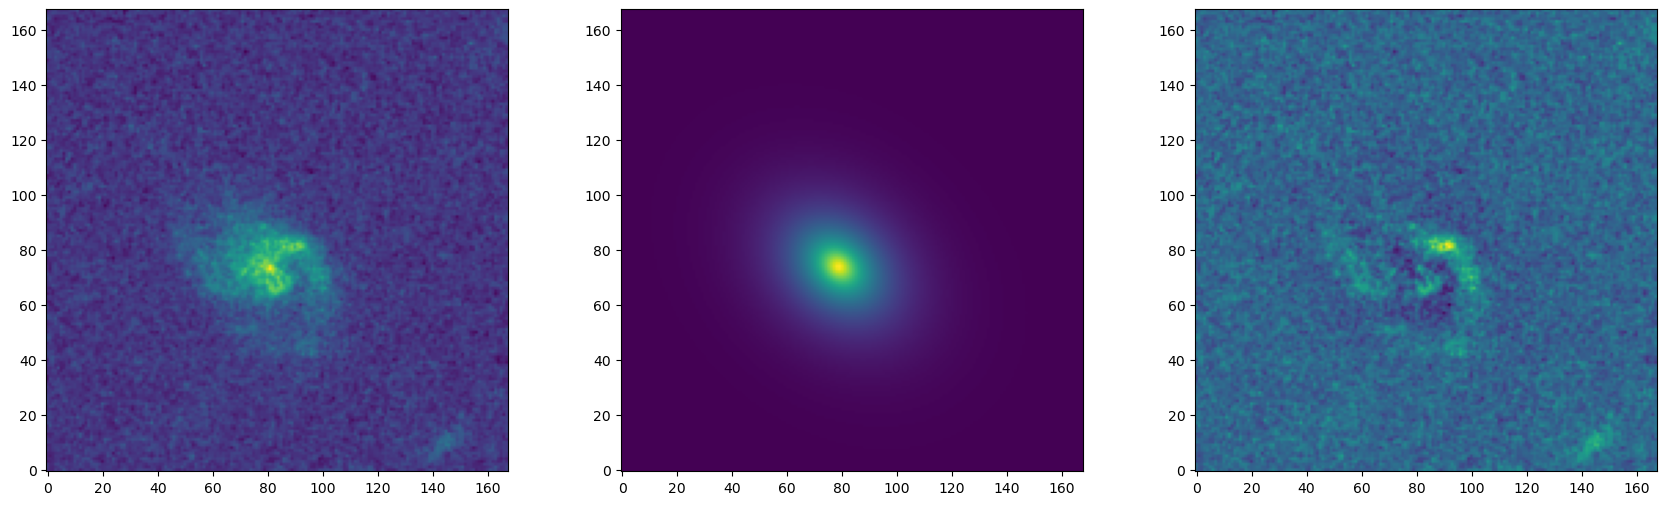

{'x0': -4.8102376342291135, 'y0': -9.702202976086781, 'sini': 0.6437361466807084, 'theta_int': -41.78275673388949, 'flux': 48.85838582339487, 'hlr': 0.6733842401627386}


In [61]:
# Playground for fitting.
# Try loading, displaying, and then fitting an image.
#plt.imshow(imap_dict['data'],origin='lower')


imap_pars = {}
imap_pars['x0'] = -5.
imap_pars['y0'] = -10. 
imap_pars['flux'] = np.sum(imap_dict['data'])
imap_pars['hlr'] = .5
imap_pars['sini'] = 0.9
imap_pars['theta_int'] = -45
Nrow, Ncol = imap_dict['data'].shape
Nx, Ny = Ncol, Nrow

# Now try running an optimizer

def f(pars):
    ipars = imap_theta2pars(pars)
    r = imap_residuals(ipars, imap_dict['data'], imap_dict['hdr'], imap_dict['weights'], imap_dict['mask'], psf=imap_dict['psf'])
    return r

# Parameter order:
'''
pars['x0'],
pars['y0'],
pars['sini'],
pars['theta_int'],
pars['flux'],
pars['hlr'],
'''
lobounds = np.zeros(6)
hibounds = np.repeat(np.inf,6)
#x0
lobounds[0] = -50
hibounds[0] = 50
#y0
lobounds[1] = -50
hibounds[1] = 50

#sini
lobounds[2] = 0
hibounds[2] = 1.

# theta_int
lobounds[3] = -90
hibounds[3] = 90

result = least_squares(f,startpars,verbose=2, bounds=  (lobounds,hibounds))

bestfit = imap_theta2pars(result.x)
imap_model = get_imap_model(bestfit, imap_dict['hdr'],Nx,Ny,psf=imap_dict['psf'])
imap_resid = imap_residuals(bestfit, imap_dict['data'], imap_dict['hdr'], imap_dict['weights'], imap_dict['mask'], psf=imap_dict['psf'])
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,nrows=1,figsize=(21,6))
ax1.imshow(imap_dict['data'],origin='lower')
ax2.imshow(imap_model,origin='lower')
ax3.imshow(imap_resid.reshape(imap_model.shape),origin='lower')
plt.show()

print(bestfit)

In [42]:
least_squares?

Signature:
least_squares(
    fun,
    x0,
    jac='2-point',
    bounds=(-inf, inf),
    method='trf',
    ftol=1e-08,
    xtol=1e-08,
    gtol=1e-08,
    x_scale=1.0,
    loss='linear',
    f_scale=1.0,
    diff_step=None,
    tr_solver=None,
    tr_options=None,
    jac_sparsity=None,
    max_nfev=None,
    verbose=0,
    args=(),
    kwargs=None,
)
Docstring:
Solve a nonlinear least-squares problem with bounds on the variables.

Given the residuals f(x) (an m-D real function of n real
variables) and the loss function rho(s) (a scalar function), `least_squares`
finds a local minimum of the cost function F(x)::

    minimize F(x) = 0.5 * sum(rho(f_i(x)**2), i = 0, ..., m - 1)
    subject to lb <= x <= ub

The purpose of the loss function rho(s) is to reduce the influence of
outliers on the solution.

Parameters
----------
fun : callable
    Function which computes the vector of residuals, with the signature
    ``fun(x, *args, **kwargs)``, i.e., the minimization proceeds with
    res

In [7]:
log_posterior(theta0, vmap_dict, imap_dict, priors)

-332351.9300007157

(400000, 15)


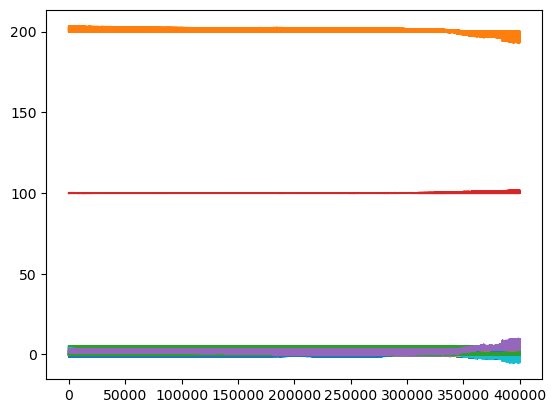

In [ ]:
burn_in = 1000
thin_by = 1
flat_samples = sampler.get_chain(discard=burn_in, thin=thin_by, flat=True)
print(flat_samples.shape)

plt.plot(flat_samples)

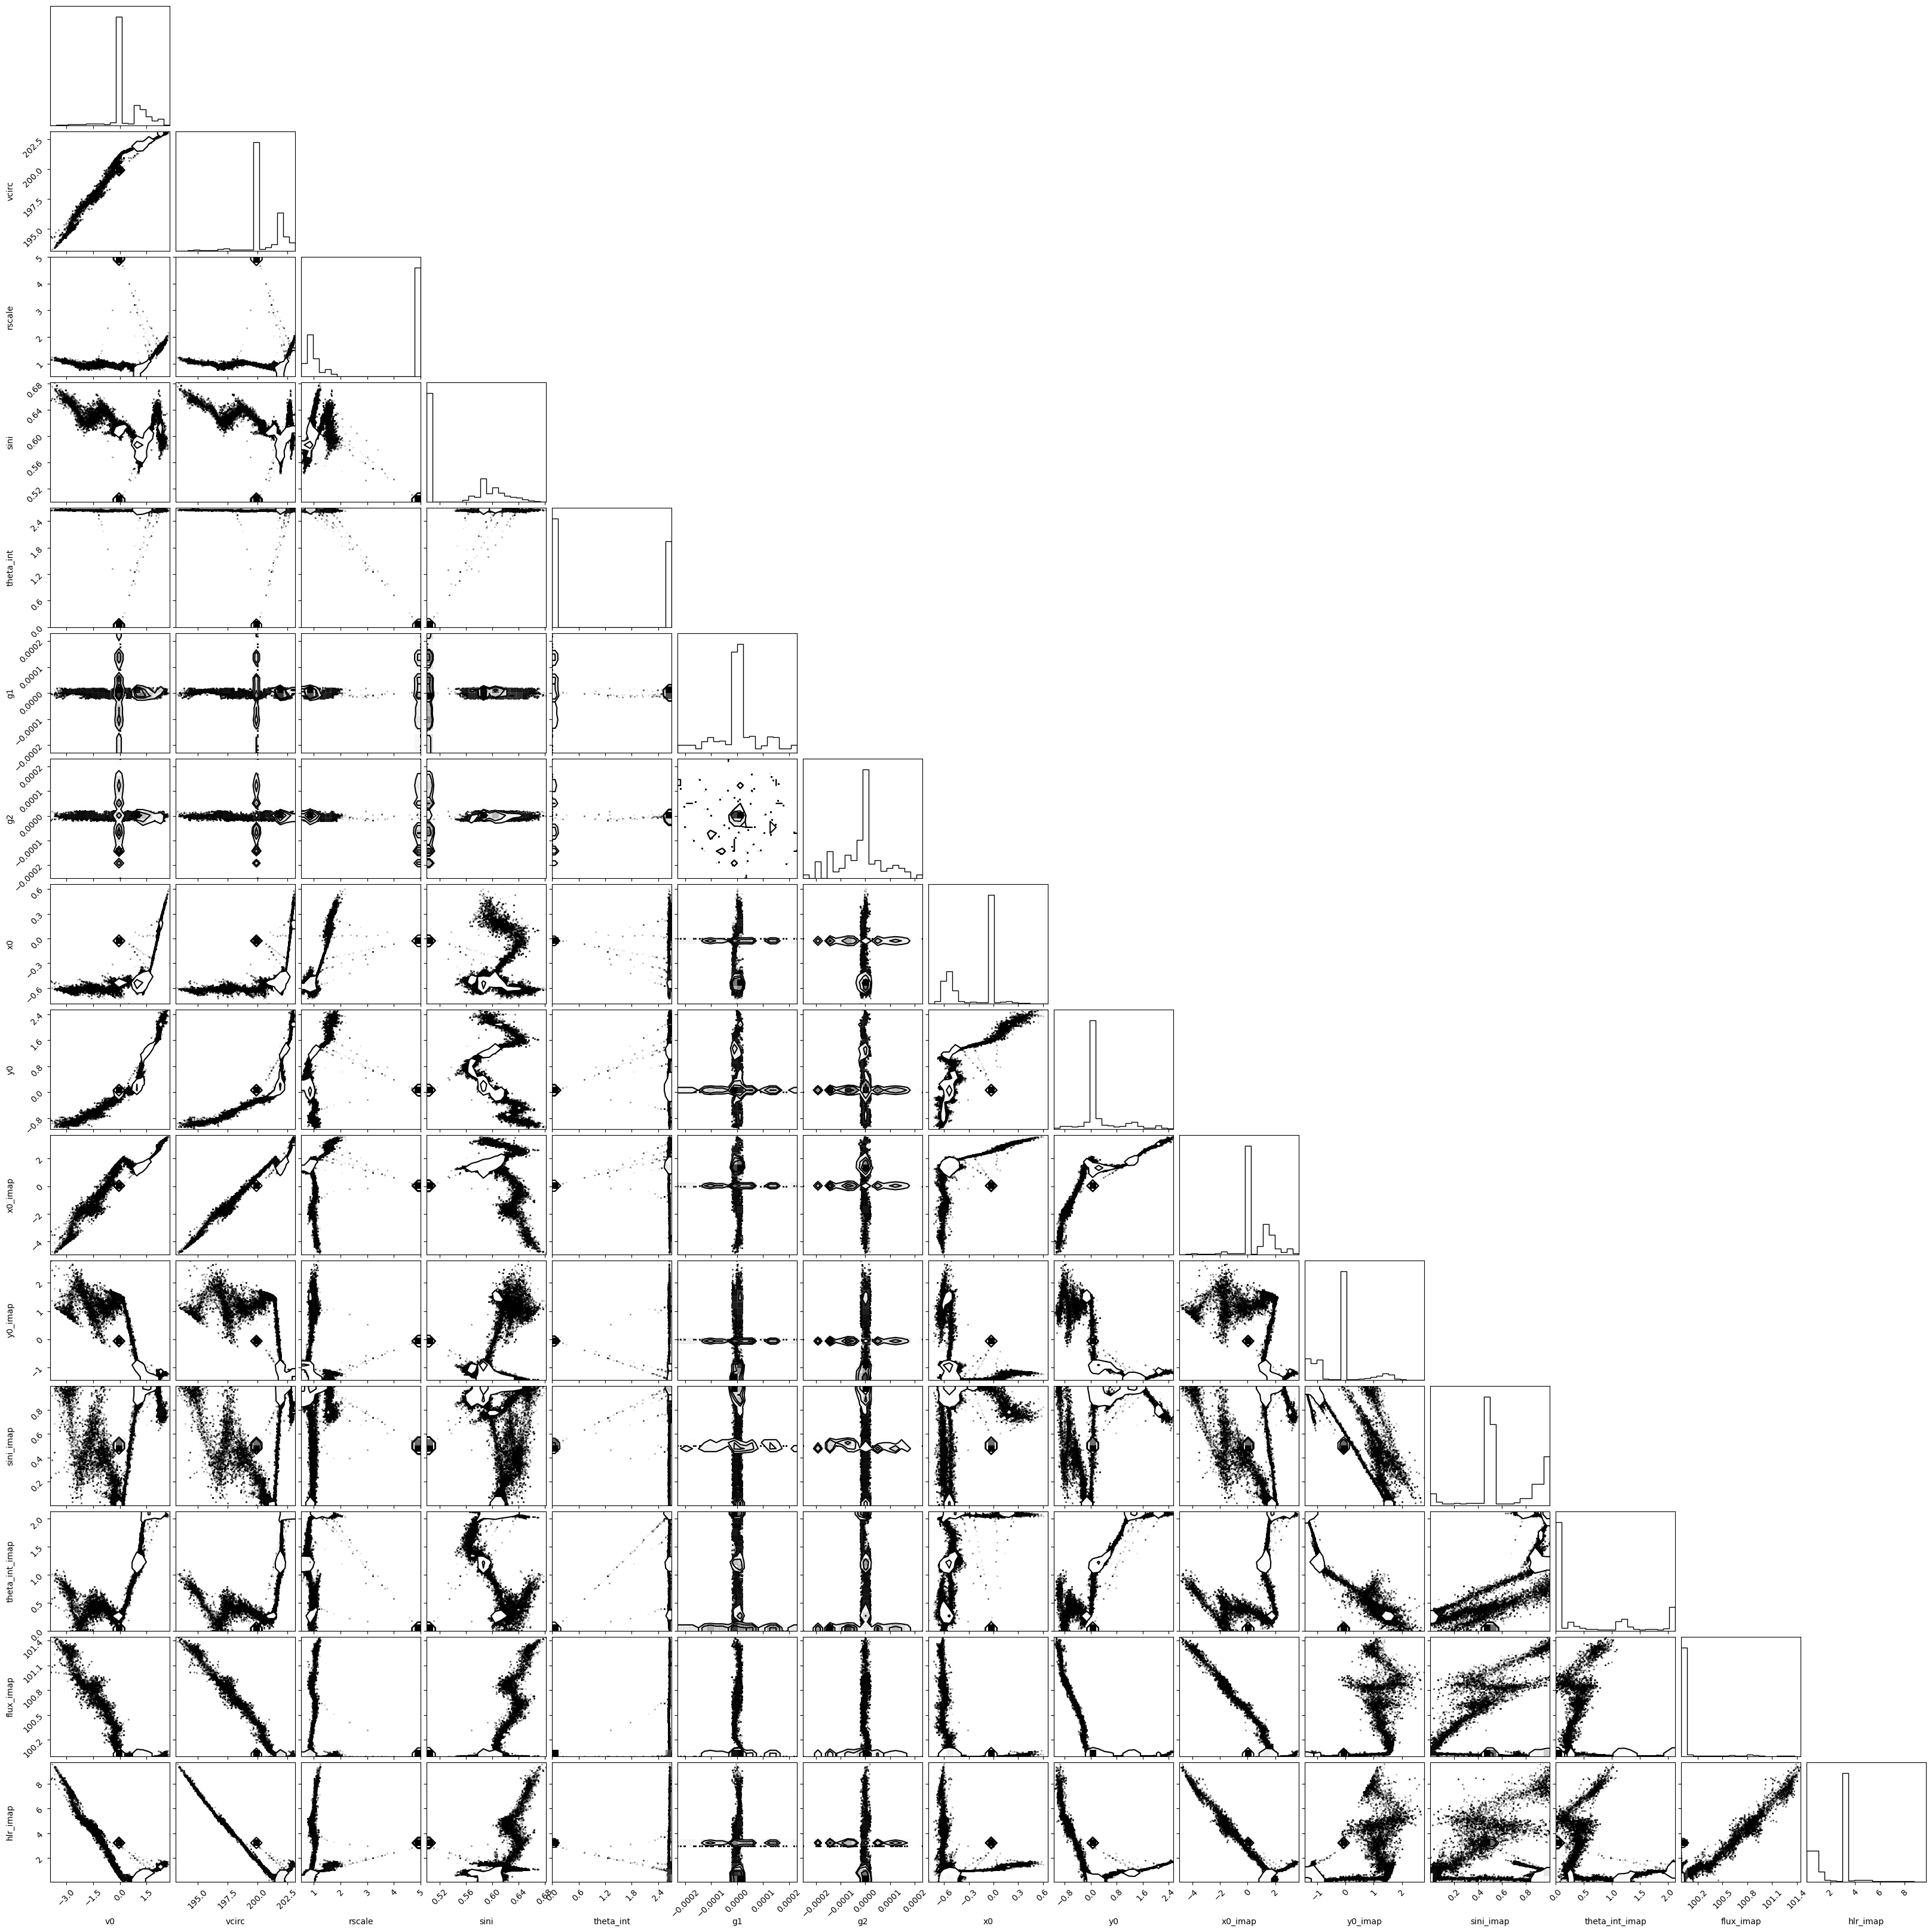

In [ ]:
fig = corner.corner(
    flat_samples, labels=param_names
);